In [1]:
import os
import numpy as np
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import GenericUnivariateSelect, mutual_info_classif, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LogisticRegression

In [2]:
data = pd.read_excel('./ID_data_mass_18122012.xlsx', sheet_name='VU')

/home/pavel/.local/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


In [3]:
data.head(5)

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,осредненные параметры,Unnamed: 5,Unnamed: 6,На конец режима,Unnamed: 8,Unnamed: 9,...,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33
0,NaN,NaN,Глубина манометра,Dшт,Руст,Рзаб,Pлин,Руст,Рзаб,Рлин,...,Рпл. Тек (Карноухов),Pсб,Pсб,Ro_g,Ro_c,Ro_w,Удельная плотность газа,G_total,КГФ,КГФ
1,№,дд.мм.гггг,м,мм,бара,бара,бара,бар,бар,бар,...,МПа,атм,бар,кг/м3,кг/м3,кг/м3,б/р,кг/с,г/м3,т/тыс.м3
2,804,2008-06-05 00:00:00,3576.3,7.94,249.6,370.1,101.8,249,359.6,101.8,...,-,93.6,92.376018,0.806017,801,1000,0.669449,2.782623,311.9094,NaN
3,804,2008-06-06 00:00:00,3576.3,9.53,233.5,364.6,101.3,231,338.1,102.4,...,-,92.9,91.685171,0.806017,801,1000,0.669449,3.697781,288.6003,NaN
4,804,2008-06-07 00:00:00,3576.3,11.11,213.4,357.1,101.6,211,314.8,100.6,...,-,91.4,90.204787,0.806017,801,1000,0.669449,4.515073,248.7906,NaN


In [4]:
data.shape

(187, 34)

In [5]:
data.iat[0, 4] += " (ос. пар.)"
data.iat[0, 5] += " (ос. пар.)"
data.iat[0, 6] += " (ос. пар.)"

data.iat[0, 7] += " (кон. реж.)"
data.iat[0, 8] += " (кон. реж.)"
data.iat[0, 9] += " (кон. реж.)"

data.iat[0, 14] += " (ст. усл.)"
data.iat[0, 15] += " (ст. усл.)"
data.iat[0, 16] += " (ст. усл.)"
data.iat[0, 17] += " (ст. усл.)"

data.iat[0, 18] += " (лин. усл.)"
data.iat[0, 19] += " (лин. усл.)"
data.iat[0, 20] += " (лин. усл.)"

In [6]:
data.head(5)

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,осредненные параметры,Unnamed: 5,Unnamed: 6,На конец режима,Unnamed: 8,Unnamed: 9,...,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33
0,NaN,NaN,Глубина манометра,Dшт,Руст (ос. пар.),Рзаб (ос. пар.),Pлин (ос. пар.),Руст (кон. реж.),Рзаб (кон. реж.),Рлин (кон. реж.),...,Рпл. Тек (Карноухов),Pсб,Pсб,Ro_g,Ro_c,Ro_w,Удельная плотность газа,G_total,КГФ,КГФ
1,№,дд.мм.гггг,м,мм,бара,бара,бара,бар,бар,бар,...,МПа,атм,бар,кг/м3,кг/м3,кг/м3,б/р,кг/с,г/м3,т/тыс.м3
2,804,2008-06-05 00:00:00,3576.3,7.94,249.6,370.1,101.8,249,359.6,101.8,...,-,93.6,92.376018,0.806017,801,1000,0.669449,2.782623,311.9094,NaN
3,804,2008-06-06 00:00:00,3576.3,9.53,233.5,364.6,101.3,231,338.1,102.4,...,-,92.9,91.685171,0.806017,801,1000,0.669449,3.697781,288.6003,NaN
4,804,2008-06-07 00:00:00,3576.3,11.11,213.4,357.1,101.6,211,314.8,100.6,...,-,91.4,90.204787,0.806017,801,1000,0.669449,4.515073,248.7906,NaN


In [7]:
# собираем первые строки с названием и единицей измерения в одну
for i in range(34):
    if pd.isna(data.iat[0, i]):
        data.iat[0, i] = data.iat[1, i]
    else:
        data.iat[0, i] = data.iat[0, i] + ", " + data.iat[1, i]

In [8]:
# убираем лишнюю
data.drop([1], axis = 0, inplace = True)

In [9]:
# делаем объединенную строку заголовком
data.rename(columns=data.iloc[0], inplace = True)
data.drop([0], inplace = True)

In [10]:
data.head(5)

,№,дд.мм.гггг,"Глубина манометра, м","Dшт, мм","Руст (ос. пар.), бара","Рзаб (ос. пар.), бара","Pлин (ос. пар.), бара","Руст (кон. реж.), бар","Рзаб (кон. реж.), бар","Рлин (кон. реж.), бар",...,"Рпл. Тек (Карноухов), МПа","Pсб, атм","Pсб, бар","Ro_g, кг/м3","Ro_c, кг/м3","Ro_w, кг/м3","Удельная плотность газа , б/р","G_total, кг/с","КГФ, г/м3","КГФ, т/тыс.м3"
2,804,2008-06-05 00:00:00,3576.3,7.94,249.6,370.1,101.8,249,359.6,101.8,...,-,93.6,92.376018,0.806017,801,1000,0.669449,2.782623,311.9094,NaN
3,804,2008-06-06 00:00:00,3576.3,9.53,233.5,364.6,101.3,231,338.1,102.4,...,-,92.9,91.685171,0.806017,801,1000,0.669449,3.697781,288.6003,NaN
4,804,2008-06-07 00:00:00,3576.3,11.11,213.4,357.1,101.6,211,314.8,100.6,...,-,91.4,90.204787,0.806017,801,1000,0.669449,4.515073,248.7906,NaN
5,804,2008-06-08 00:00:00,3576.3,12.7,191.6,347.4,98.4,187,291.5,99,...,-,89.2,88.033555,0.806017,801,1000,0.669449,5.217673,223.5591,NaN
6,804,2008-06-09 00:00:00,3576.3,14.29,171.9,337.7,99.2,169,270.3,99.5,...,-,89.7,88.527017,0.806017,801,1000,0.669449,5.765092,215.1486,NaN


In [11]:
# приводим признак КГФ к г/м3
for i in range(185):
    if pd.isna(data.iat[i, 32]):
        if pd.isna(data.iat[i, 33]) == False:
            data.iat[i, 32] = data.iat[i, 33] * 1000

In [12]:
# убираем строки где обе целевые переменные равны nan
data = data.loc[((pd.isna(data['КГФ, г/м3']) == False)) | (pd.isna(data['G_total, кг/с']) == False)]
data = data.drop(columns=['КГФ, т/тыс.м3'])

In [13]:
data.shape

(93, 33)

In [14]:
# псевдо пропуски заполнить nan
for d in data.columns:
    data.loc[data[d] == "-", d] = np.nan
    data.loc[data[d] == "не спускался", d] = np.nan
    data.loc[data[d] == "nan", d] = np.nan

In [15]:
# посчитать процентное соотношение пропусков для каждого признака
for d in data.columns:
    if data[d].isna().sum() / len(data[d]) * 100 != 0:
        print(d, "--", data[d].isna().sum() / len(data[d]) * 100, "%")

Глубина манометра, м -- 3.225806451612903 %
Рзаб (ос. пар.), бара -- 3.225806451612903 %
Рзаб (кон. реж.), бар -- 3.225806451612903 %
Тна шлейфе,  С -- 35.483870967741936 %
Тзаб,  С -- 3.225806451612903 %
Дебит смеси (ст. усл.), 1000 м3/сут -- 4.301075268817205 %
Рпл. Тек (послед точка на КВД), МПа -- 5.376344086021505 %
Рпл. Тек (Расчет по КВД), МПа -- 12.903225806451612 %
Рпл. Тек (Карноухов), МПа -- 31.182795698924732 %
Ro_g, кг/м3 -- 75.26881720430107 %
Ro_w, кг/м3 -- 75.26881720430107 %
G_total, кг/с -- 75.26881720430107 %


In [16]:
# убираем первые два столбца, номер и дата неописательны
data.drop(columns=["№", "дд.мм.гггг"], inplace=True)

In [17]:
# имеют по 75% пропусков
data.drop(columns=["Ro_w, кг/м3", "Ro_g, кг/м3"], inplace=True)

In [18]:
data.shape

(93, 29)

In [19]:
for d in data.columns:
    if data[d].isna().sum() / len(data[d]) * 100 != 0:
        print(d, "--", data[d].isna().sum() / len(data[d]) * 100, "%")

Глубина манометра, м -- 3.225806451612903 %
Рзаб (ос. пар.), бара -- 3.225806451612903 %
Рзаб (кон. реж.), бар -- 3.225806451612903 %
Тна шлейфе,  С -- 35.483870967741936 %
Тзаб,  С -- 3.225806451612903 %
Дебит смеси (ст. усл.), 1000 м3/сут -- 4.301075268817205 %
Рпл. Тек (послед точка на КВД), МПа -- 5.376344086021505 %
Рпл. Тек (Расчет по КВД), МПа -- 12.903225806451612 %
Рпл. Тек (Карноухов), МПа -- 31.182795698924732 %
G_total, кг/с -- 75.26881720430107 %


In [20]:
data.columns

Index(['Глубина манометра, м', 'Dшт, мм', 'Руст (ос. пар.), бара',
       'Рзаб (ос. пар.), бара', 'Pлин (ос. пар.), бара',
       'Руст (кон. реж.), бар', 'Рзаб (кон. реж.), бар',
       'Рлин (кон. реж.), бар', 'Туст,  С', 'Тна шлейфе,  С', 'Тзаб,  С',
       'Tлин,  С', 'Дебит газа (ст. усл.), 1000 м3/сут',
       'Дебит ст. конд. (ст. усл.), м3/сут', 'Дебит воды (ст. усл.), м3/сут',
       'Дебит смеси (ст. усл.), 1000 м3/сут', 'Дебит гааз (лин. усл.), м3/сут',
       'Дебит кон нестабильный (лин. усл.), м3/сут',
       'Дебит воды (лин. усл.), м3/сут', 'Нэф, м',
       'Рпл. Тек (послед точка на КВД), МПа', 'Рпл. Тек (Расчет по КВД), МПа',
       'Рпл. Тек (Карноухов), МПа', 'Pсб,  атм', 'Pсб,  бар', 'Ro_c, кг/м3',
       'Удельная плотность газа , б/р', 'G_total, кг/с', 'КГФ, г/м3'],
      dtype='object')

In [ ]:
#for d in data.columns:
#    print(d, "--", sorted(list(pd.unique(data[d]))))
#    print("-"*45)

In [22]:
data.head(5)
#new_data.shape

,"Глубина манометра, м","Dшт, мм","Руст (ос. пар.), бара","Рзаб (ос. пар.), бара","Pлин (ос. пар.), бара","Руст (кон. реж.), бар","Рзаб (кон. реж.), бар","Рлин (кон. реж.), бар","Туст, С","Тна шлейфе, С",...,"Нэф, м","Рпл. Тек (послед точка на КВД), МПа","Рпл. Тек (Расчет по КВД), МПа","Рпл. Тек (Карноухов), МПа","Pсб, атм","Pсб, бар","Ro_c, кг/м3","Удельная плотность газа , б/р","G_total, кг/с","КГФ, г/м3"
2,3576.3,7.94,249.6,370.1,101.8,249,359.6,101.8,53,31.7,...,56.8,45.25,56.5,NaN,93.6,92.376018,801,0.669449,2.782623,311.9094
3,3576.3,9.53,233.5,364.6,101.3,231,338.1,102.4,58.8,37.6,...,56.8,45.25,56.5,NaN,92.9,91.685171,801,0.669449,3.697781,288.6003
4,3576.3,11.11,213.4,357.1,101.6,211,314.8,100.6,63.6,42.8,...,56.8,45.25,56.5,NaN,91.4,90.204787,801,0.669449,4.515073,248.7906
5,3576.3,12.7,191.6,347.4,98.4,187,291.5,99,64.7,46.2,...,56.8,45.25,56.5,NaN,89.2,88.033555,801,0.669449,5.217673,223.5591
6,3576.3,14.29,171.9,337.7,99.2,169,270.3,99.5,64,49.4,...,56.8,45.25,56.5,NaN,89.7,88.527017,801,0.669449,5.765092,215.1486


In [23]:
#data.shape

In [24]:
# gain_ratio
from info_gain import info_gain

mas = {}
for d in data.columns:
    mas[d] = info_gain.info_gain_ratio(data['КГФ, г/м3'], data[d])
    
sorted(mas.items(), key=lambda item: (item[1], item[0]))

[('Dшт, мм', 0.6004587287518505),
 ('Нэф, м', 0.6015351362246341),
 ('Рпл. Тек (Карноухов), МПа', 0.6137684601722869),
 ('Удельная плотность газа , б/р', 0.6164879741178141),
 ('Рпл. Тек (послед точка на КВД), МПа', 0.6194615266219693),
 ('Глубина манометра, м', 0.6205915196615617),
 ('Рпл. Тек (Расчет по КВД), МПа', 0.6208482705369726),
 ('Ro_c, кг/м3', 0.6232861606282236),
 ('Тна шлейфе,  С', 0.6251255824154861),
 ('Дебит воды (лин. усл.), м3/сут', 0.6312627417988528),
 ('Туст,  С', 0.6313667318724031),
 ('Тзаб,  С', 0.6371019789364301),
 ('Pсб,  бар', 0.6377390852750784),
 ('Pсб,  атм', 0.6377390852750785),
 ('Дебит воды (ст. усл.), м3/сут', 0.6387113667478977),
 ('Руст (кон. реж.), бар', 0.6404401834536029),
 ('Руст (ос. пар.), бара', 0.641043707961092),
 ('Рлин (кон. реж.), бар', 0.6412181459147025),
 ('Рзаб (ос. пар.), бара', 0.6413914197590613),
 ('Tлин,  С', 0.6414565206718515),
 ('Дебит смеси (ст. усл.), 1000 м3/сут', 0.6414565206718515),
 ('Рзаб (кон. реж.), бар', 0.641563541

In [25]:
# описательная статистика
for d in data.columns:
    print("Признак: ", d)
    print(f"Количество = {len(data[d])}")
    print(f"Процент пропусков = {data[d].isna().sum() / len(data[d]) * 100}%")
    data_without_nans = np.array([x for x in data[d] if str(x) != "nan" ])
    print(f"Минимум = {data_without_nans.min()}")
    print(f"Среднее: = {data_without_nans.mean()}")
    perc_25, median, perc_75 = np.percentile(data_without_nans, [25, 50, 75])
    print(f"Первый квартиль = {perc_25}")
    print(f"Медиана = {median}")
    print(f"Третий квартиль = {perc_75}")
    print(f"Максимум = {data[d].max()}")
    print(f"Стандартное отклонение = {data[d].std()}")
    print(f"Мощность = {len(list(pd.unique(data[d])))}")
    print(f"Интерквартильный размах: = {perc_75-perc_25}")
    print("="*50)

Признак:  Глубина манометра, м
Количество = 93
Процент пропусков = 3.225806451612903%
Минимум = 3276.0
Среднее: = 3524.0866666666666
Первый квартиль = 3427.625
Медиана = 3579.0
Третий квартиль = 3652.25
Максимум = 3670
Стандартное отклонение = 144.47486169891752
Мощность = 21
Интерквартильный размах: = 224.625
Признак:  Dшт, мм
Количество = 93
Процент пропусков = 0.0%
Минимум = 6.35
Среднее: = 10.951182795698925
Первый квартиль = 9.53
Медиана = 11.11
Третий квартиль = 12.7
Максимум = 15.88
Стандартное отклонение = 2.42317248460269
Мощность = 10
Интерквартильный размах: = 3.17
Признак:  Руст (ос. пар.), бара
Количество = 93
Процент пропусков = 0.0%
Минимум = 138.1578947368421
Среднее: = 228.29341238459256
Первый квартиль = 201.63675
Медиана = 229.89473684210526
Третий квартиль = 252.0
Максимум = 337.1081081081081
Стандартное отклонение = 41.89723834031322
Мощность = 87
Интерквартильный размах: = 50.363249999999994
Признак:  Рзаб (ос. пар.), бара
Количество = 93
Процент пропусков = 3.225

In [26]:
data.corr()

""


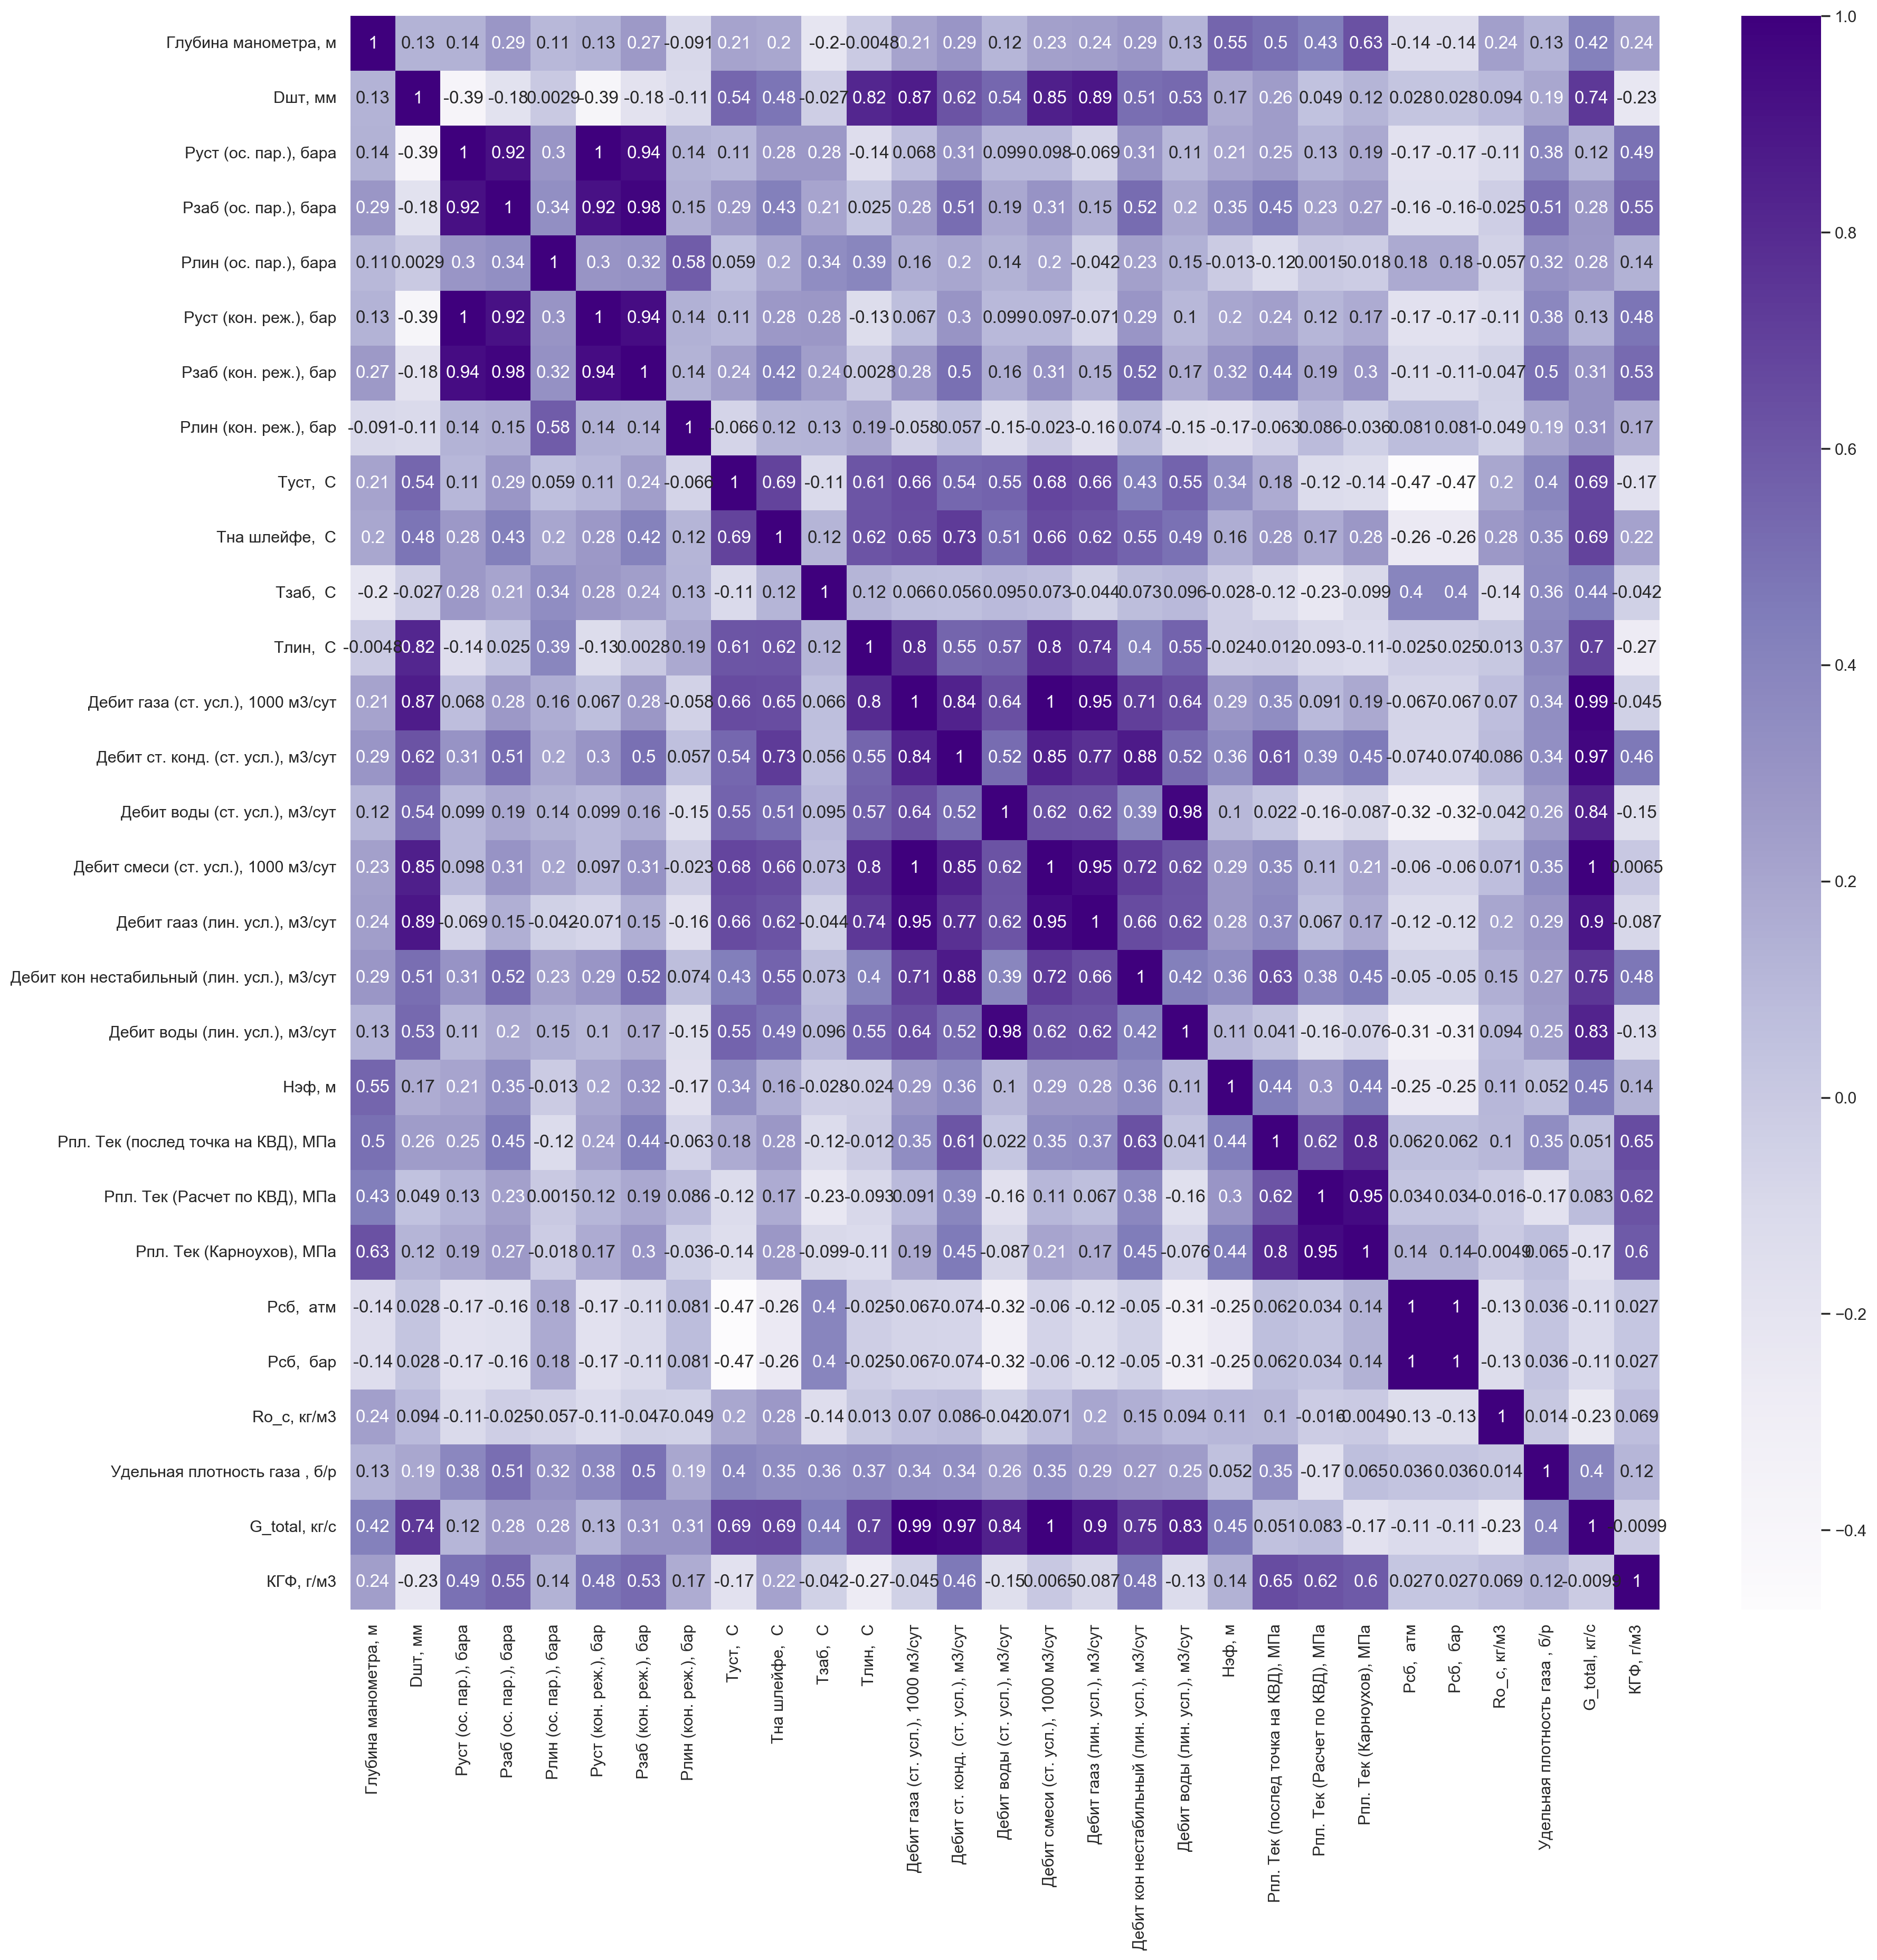

In [27]:
# тепловая карта признаков
import seaborn as sns
%matplotlib inline
data2 = data.apply(pd.to_numeric)
corr = data2.corr()
sns.set(rc={"figure.dpi":200})
sns.set(rc={'figure.figsize':(20,20)})
sns.heatmap(corr, cmap="Purples", annot=True)

In [28]:
# 30% nan, большая зависимость от более хорошего признака
data.drop(columns=['Рпл. Тек (Карноухов), МПа'], inplace=True)

# один из признаков клонов (см. тепловую карту)
data.drop(columns=['Pсб,  бар'], inplace=True)

In [29]:
#from math import nan
#import matplotlib.pyplot as plt
#import seaborn as sns
#import numpy as np

# графики распределения

#def pt(x):
    #x = data['Рпл. Тек (послед точка на КВД), МПа']
#    fig, ax = plt.subplots(ncols=1, figsize=(12, 4))
#    sns.kdeplot(x, shade=False, ax=ax)
#    kdeline = ax.lines[0]
#    xs = kdeline.get_xdata()
#    ys = kdeline.get_ydata()

#    left, right = np.percentile(x, [25, 75])
#    print(left,right)
#    plt.axvline(left, 0,1)
#    plt.axvline(right, 0,1)
#    ax.set_title('Showing quartiles')
#    ax.fill_between(xs, 0, ys, alpha=0.2)
#    plt.show()

In [30]:
for d in data.columns:
    if data[d].isna().sum() / len(data[d]) * 100 != 0:
        print(d, "--", data[d].isna().sum() / len(data[d]) * 100, "%")

Глубина манометра, м -- 3.225806451612903 %
Рзаб (ос. пар.), бара -- 3.225806451612903 %
Рзаб (кон. реж.), бар -- 3.225806451612903 %
Тна шлейфе,  С -- 35.483870967741936 %
Тзаб,  С -- 3.225806451612903 %
Дебит смеси (ст. усл.), 1000 м3/сут -- 4.301075268817205 %
Рпл. Тек (послед точка на КВД), МПа -- 5.376344086021505 %
Рпл. Тек (Расчет по КВД), МПа -- 12.903225806451612 %
G_total, кг/с -- 75.26881720430107 %


In [31]:
data['Тна шлейфе,  С'] = data['Тна шлейфе,  С'].fillna(-100)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


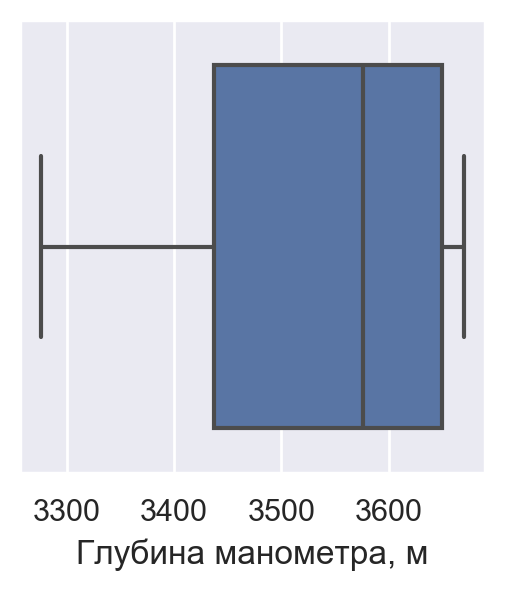

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


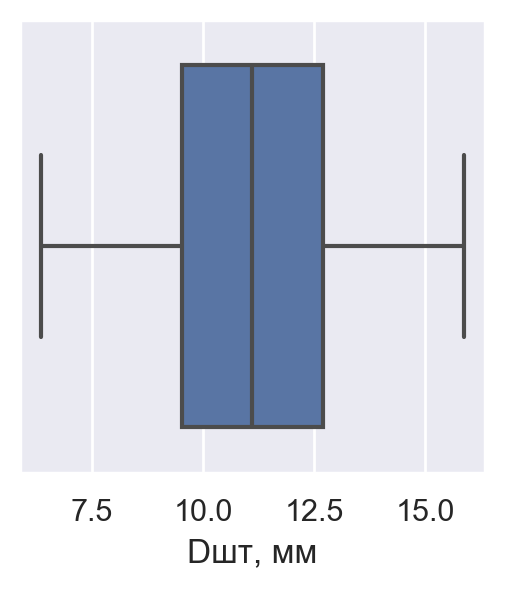

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


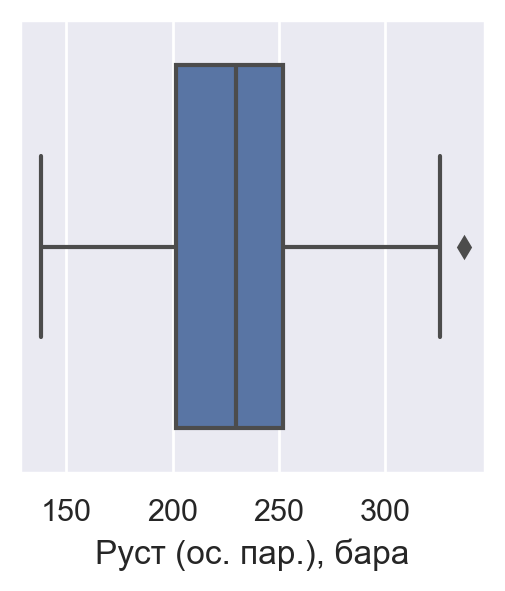

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


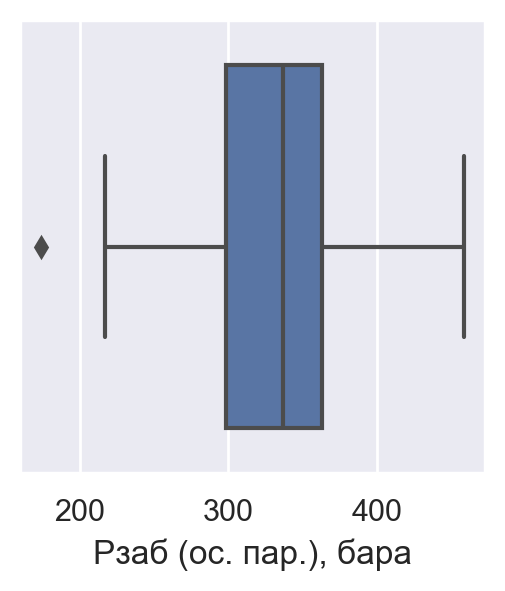

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


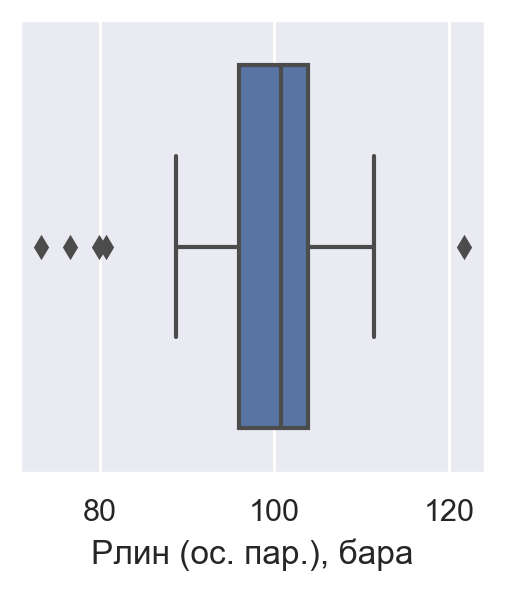

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


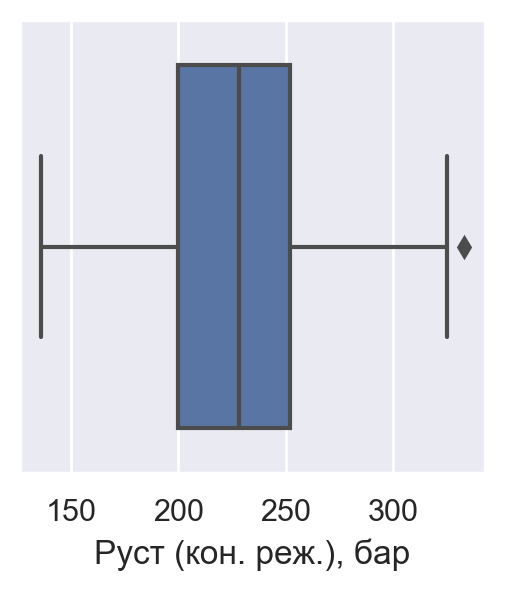

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


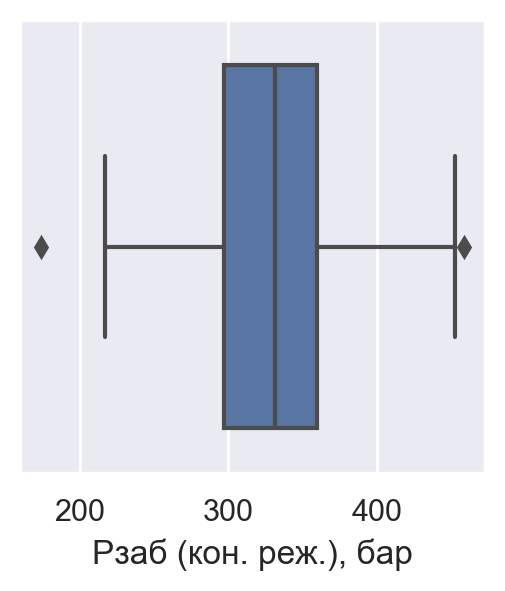

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


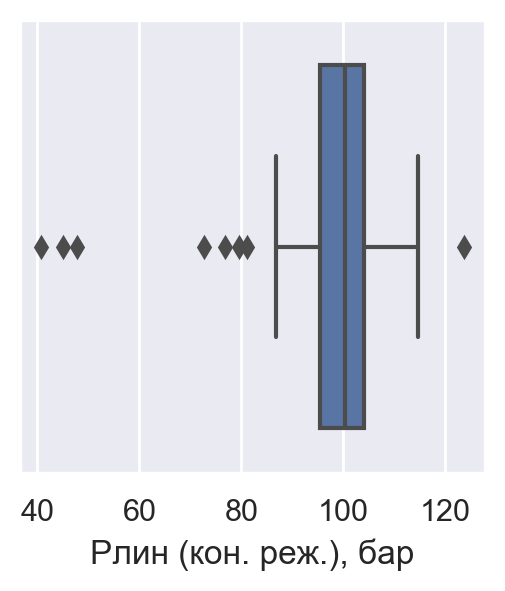

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


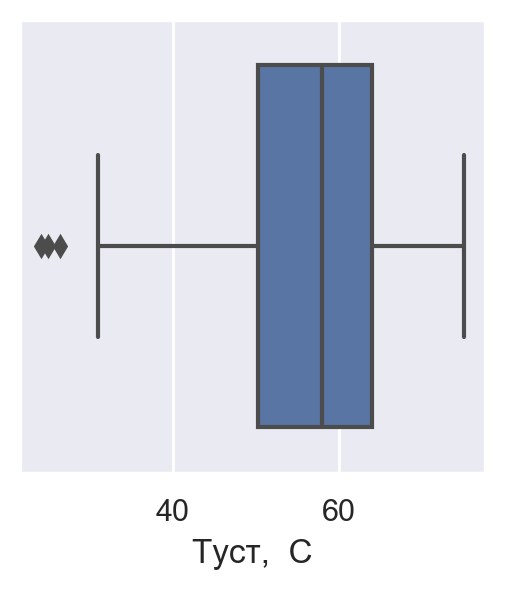

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


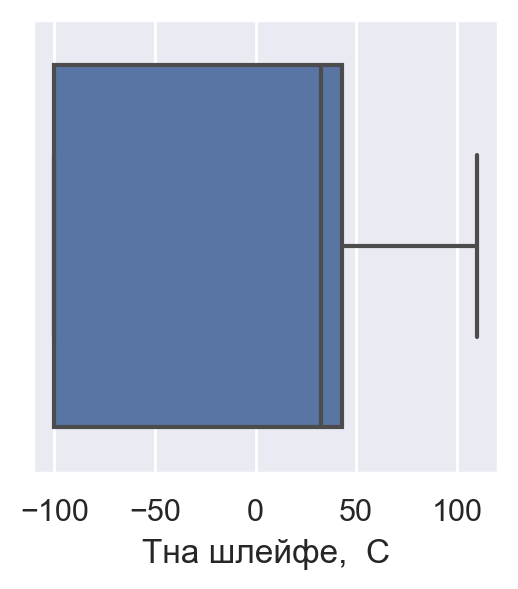

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


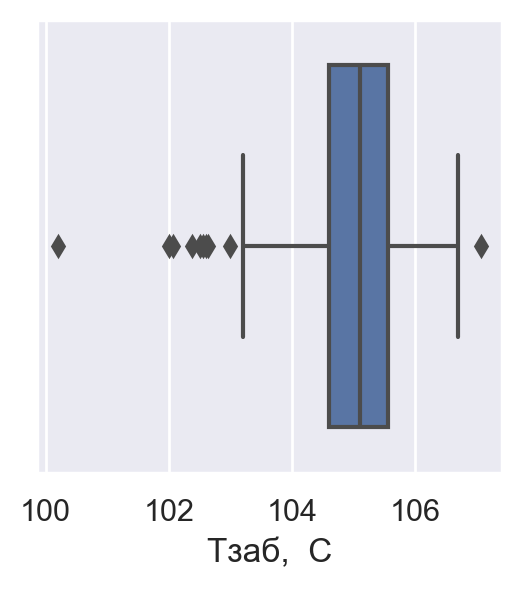

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


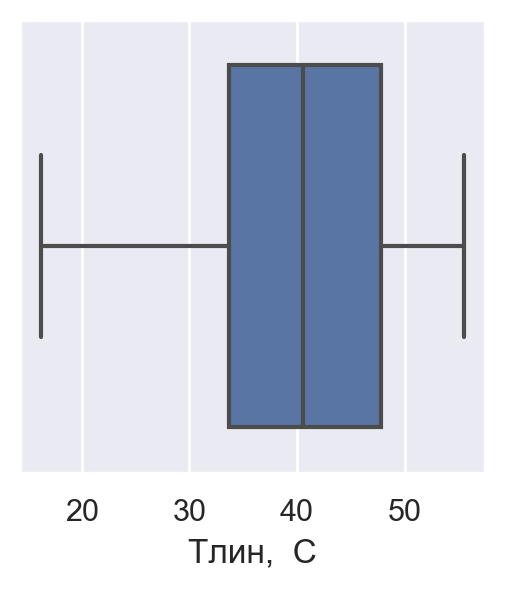

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


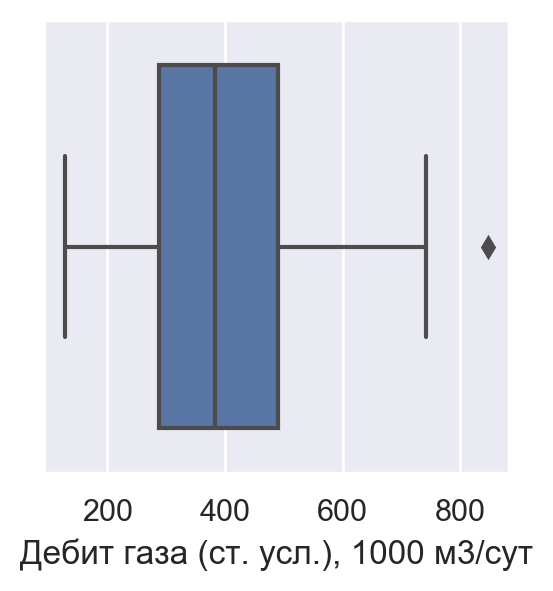

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


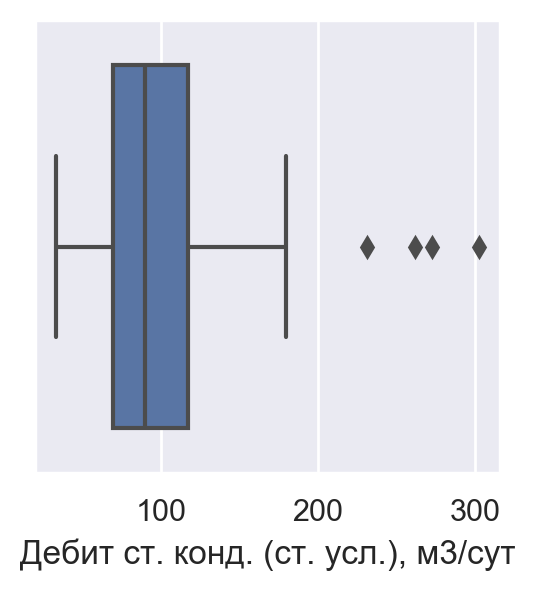

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


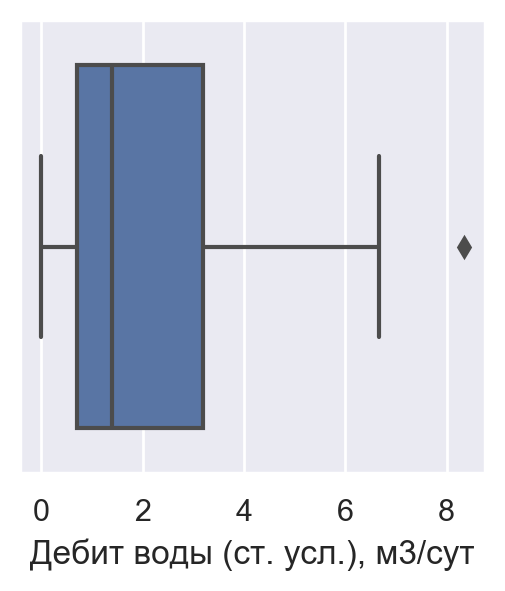

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


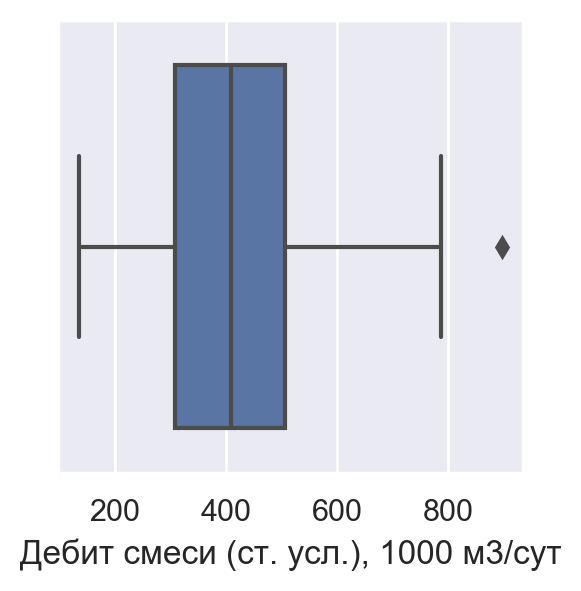

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


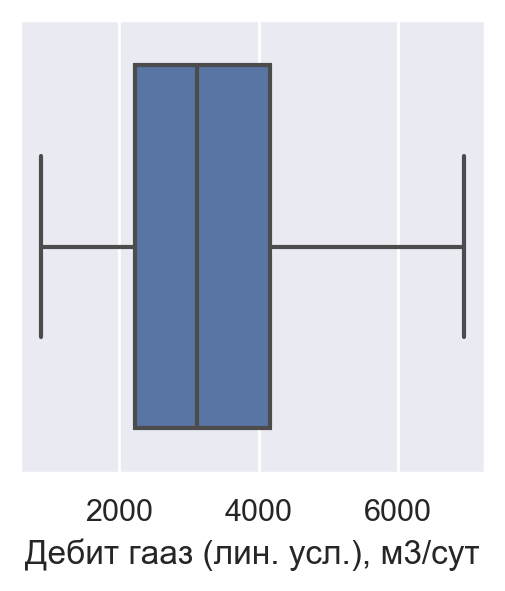

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


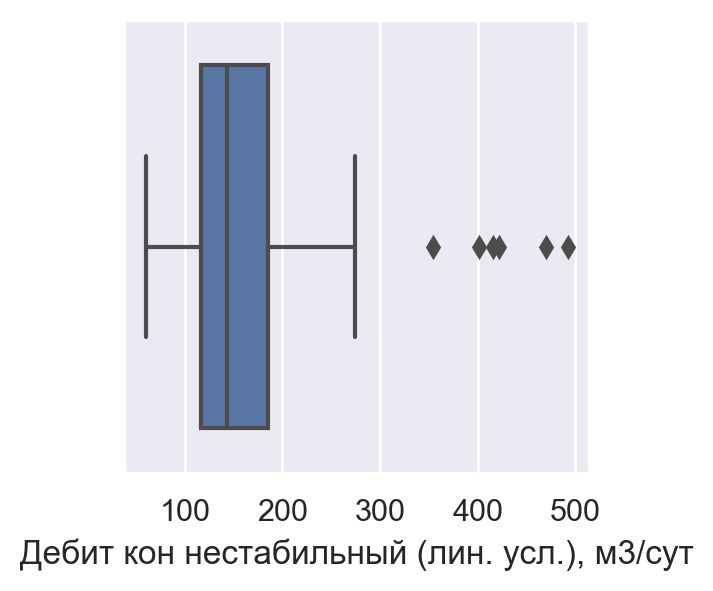

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


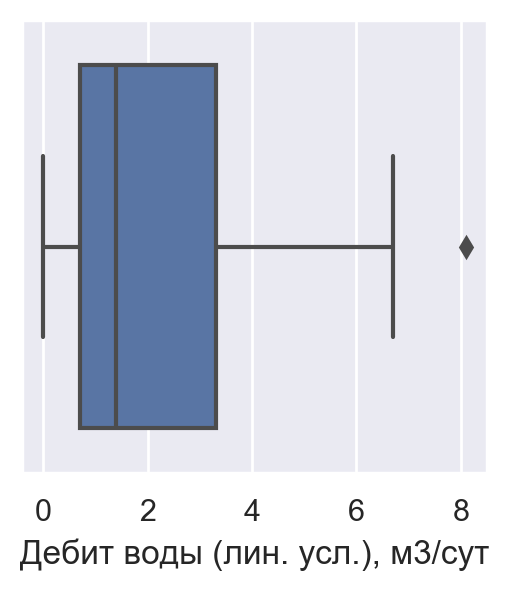

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


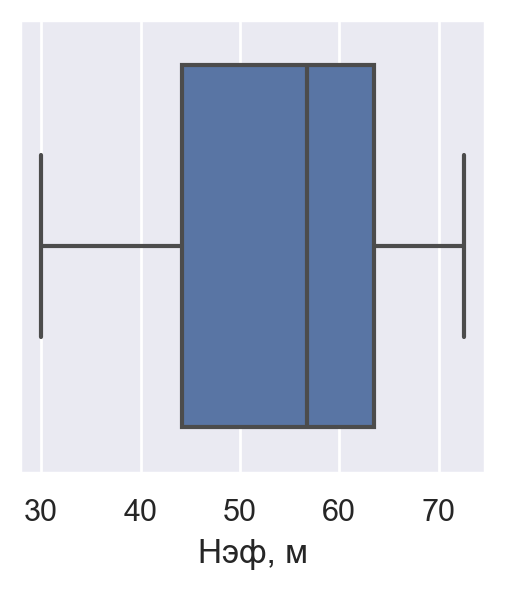

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


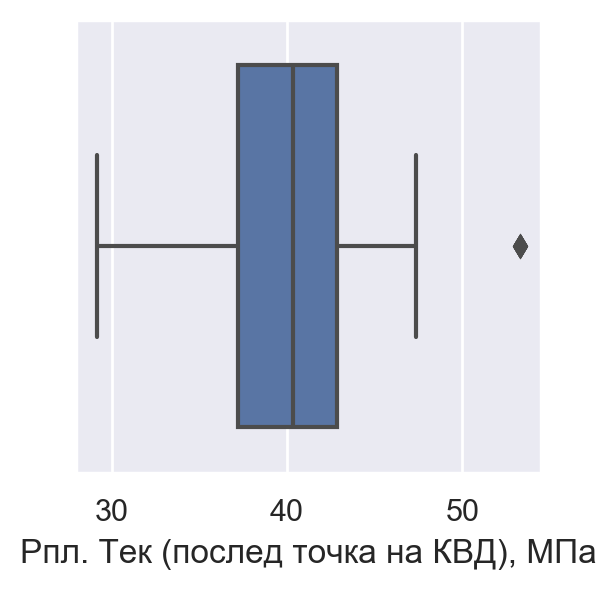

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


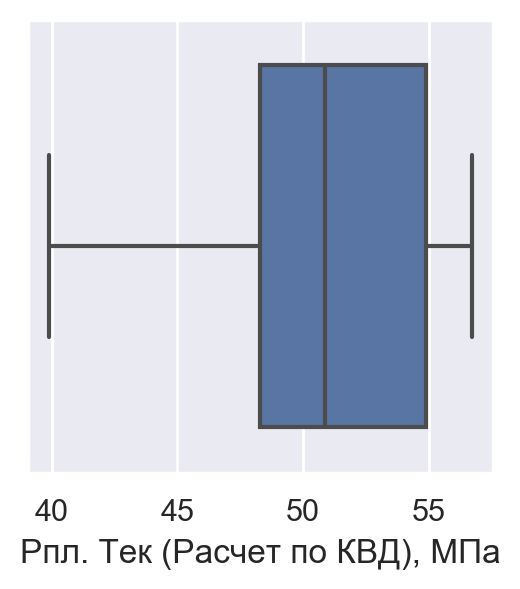

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


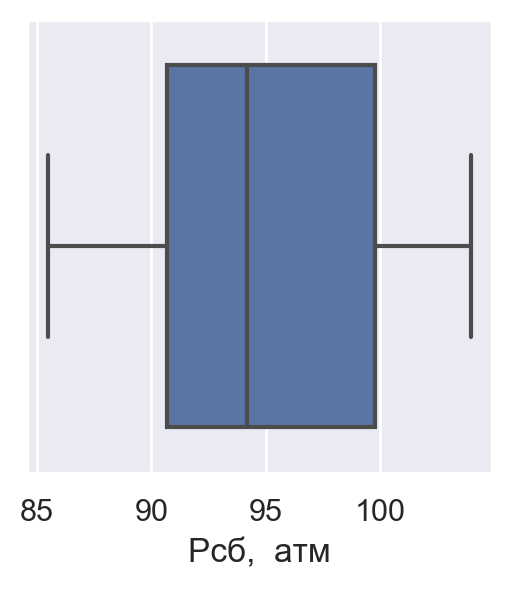

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


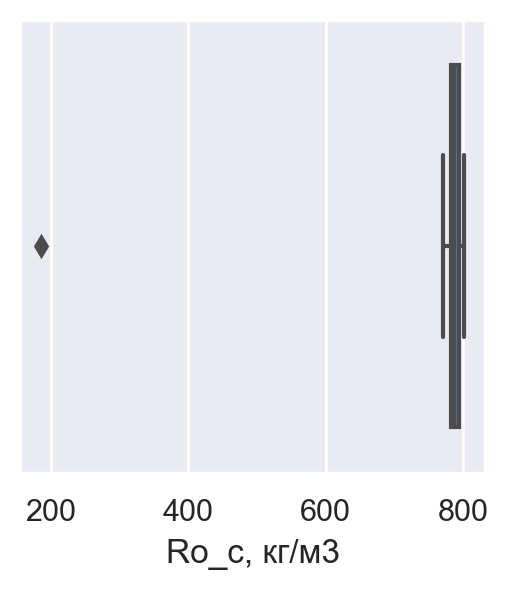

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


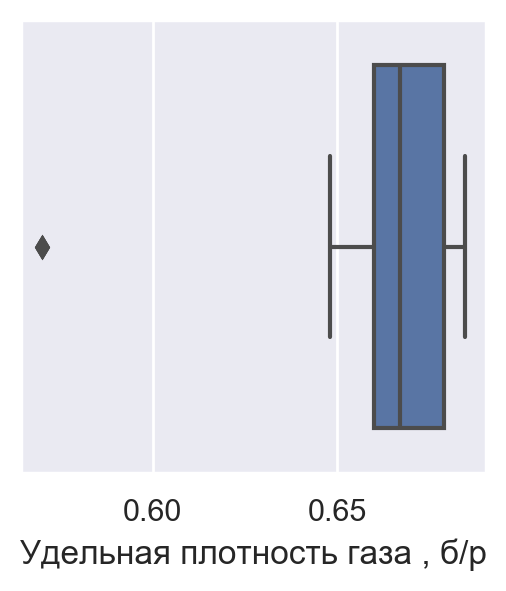

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


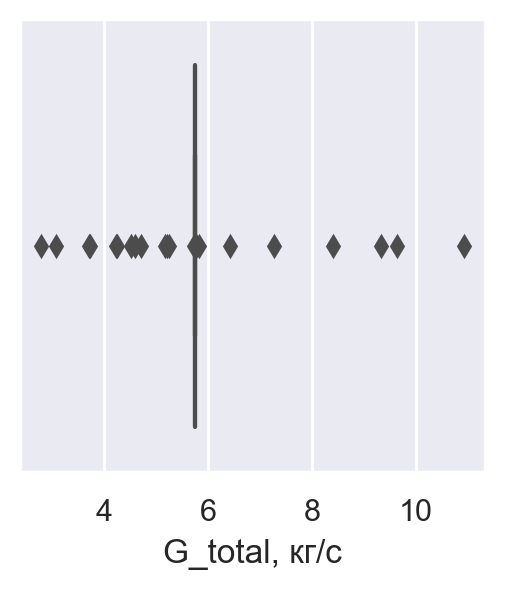

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


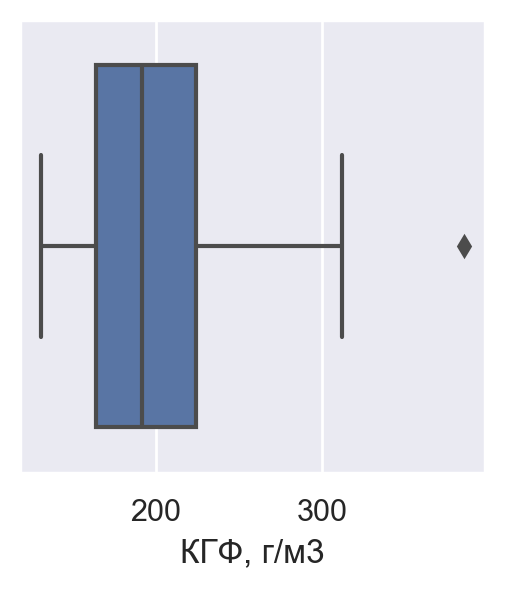

In [32]:
# заполним nan в Х средним значением

#a = data
for d in data.columns:
    data[d] = data[d].fillna(data[d].mean())
    plt.figure(figsize=(3,3))
    sns.boxplot(data[d])
    plt.show()

In [33]:
X = data.drop(columns=["G_total, кг/с", "КГФ, г/м3"])
y = data[["КГФ, г/м3"]]

In [34]:
# заполним nan в Х средним значением
#for d in X.columns:
#    X[d] = X[d].fillna(X[d].mean())

In [35]:
y = y.astype('int')

In [36]:
# важность признаков
def f(el):
    el = int(el)
    #print(el)
    if el <=150:
        return 0
    if el > 150 and el <= 200:
        return 1
    if el > 200 and el <= 250:
        return 2
    if el > 250 and el <= 300:
        return 3
    if el > 300:
        return 4

for i in range(len(y)):
    y.iat[i, 0] = f(y.iat[i, 0])

In [37]:
from sklearn.feature_selection import SelectFromModel

sel = SelectFromModel(estimator=RandomForestClassifier(n_estimators = 100, criterion="entropy"))
sel.fit(X, y)
assert hasattr(sel.estimator_, 'feature_importances_')

/usr/local/lib/python3.8/dist-packages/sklearn/feature_selection/_from_model.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


In [38]:
sel.threshold_

0.04

In [39]:
info = pd.Series(sel.estimator_.feature_importances_)
info.index = X.columns
info.sort_values(ascending=False)

Ro_c, кг/м3                                   0.072858
Рпл. Тек (послед точка на КВД), МПа           0.059489
Туст,  С                                      0.058418
Рпл. Тек (Расчет по КВД), МПа                 0.058173
Рзаб (ос. пар.), бара                         0.055860
Рзаб (кон. реж.), бар                         0.054909
Руст (ос. пар.), бара                         0.045591
Глубина манометра, м                          0.045585
Дебит воды (ст. усл.), м3/сут                 0.043835
Нэф, м                                        0.042566
Дебит гааз (лин. усл.), м3/сут                0.039390
Дебит газа (ст. усл.), 1000 м3/сут            0.039368
Pлин (ос. пар.), бара                         0.037029
Дебит ст. конд. (ст. усл.), м3/сут            0.036985
Рлин (кон. реж.), бар                         0.035246
Tлин,  С                                      0.034572
Руст (кон. реж.), бар                         0.033585
Дебит воды (лин. усл.), м3/сут                0.032954
Дебит кон 

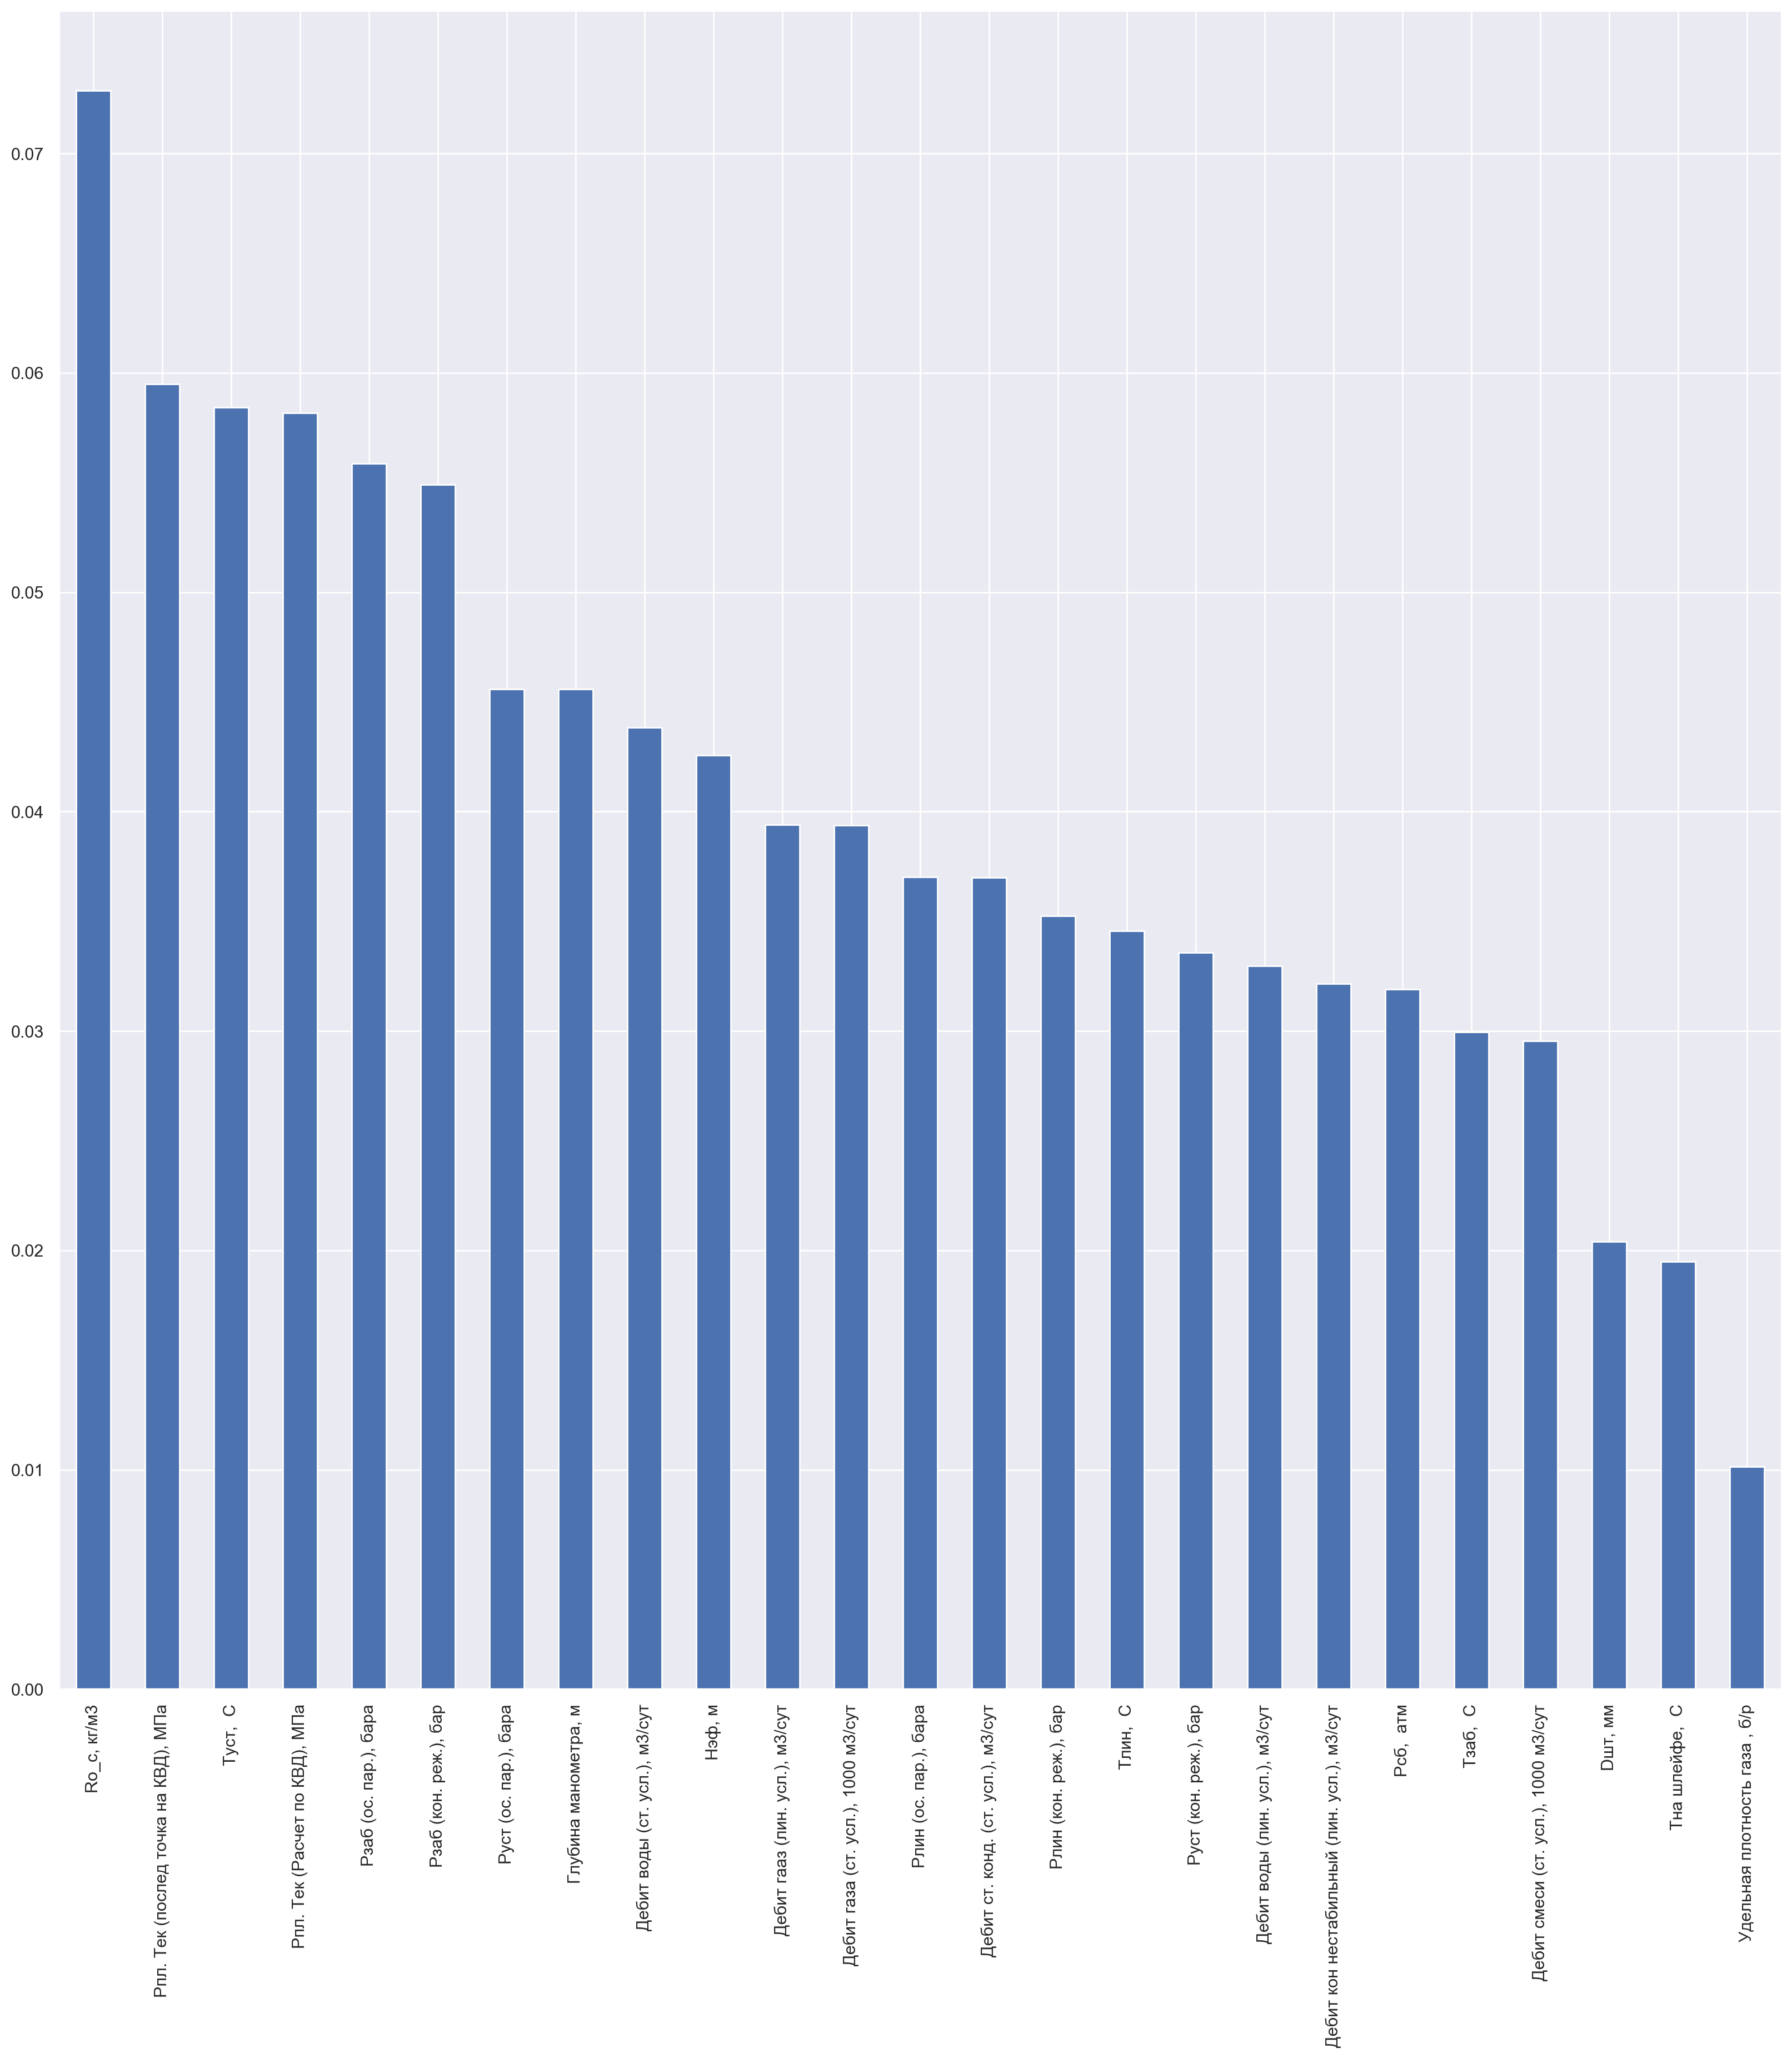

In [40]:
info.sort_values(ascending=False).plot.bar(figsize=(20, 20))

In [41]:
# удаляем столбцы, не попавшие в список важных
for d in data.columns:
    if d not in list(sel.get_feature_names_out()):
        if (d not in y.columns) and (d != 'G_total, кг/с'):
            print(d)
            data.drop(columns=[d], inplace=True)
#new_data = sel.transform(X)

Dшт, мм
Pлин (ос. пар.), бара
Руст (кон. реж.), бар
Рлин (кон. реж.), бар
Тна шлейфе,  С
Тзаб,  С
Tлин,  С
Дебит газа (ст. усл.), 1000 м3/сут
Дебит ст. конд. (ст. усл.), м3/сут
Дебит смеси (ст. усл.), 1000 м3/сут
Дебит гааз (лин. усл.), м3/сут
Дебит кон нестабильный (лин. усл.), м3/сут
Дебит воды (лин. усл.), м3/сут
Pсб,  атм
Удельная плотность газа , б/р


In [42]:
data.shape

(93, 12)

In [43]:
data.head()

,"Глубина манометра, м","Руст (ос. пар.), бара","Рзаб (ос. пар.), бара","Рзаб (кон. реж.), бар","Туст, С","Дебит воды (ст. усл.), м3/сут","Нэф, м","Рпл. Тек (послед точка на КВД), МПа","Рпл. Тек (Расчет по КВД), МПа","Ro_c, кг/м3","G_total, кг/с","КГФ, г/м3"
2,3576.3,249.6,370.1,359.6,53.0,0.4,56.8,45.25,56.5,801.0,2.782623,311.9094
3,3576.3,233.5,364.6,338.1,58.8,1.4,56.8,45.25,56.5,801.0,3.697781,288.6003
4,3576.3,213.4,357.1,314.8,63.6,1.9,56.8,45.25,56.5,801.0,4.515073,248.7906
5,3576.3,191.6,347.4,291.5,64.7,3.3,56.8,45.25,56.5,801.0,5.217673,223.5591
6,3576.3,171.9,337.7,270.3,64.0,4.6,56.8,45.25,56.5,801.0,5.765092,215.1486


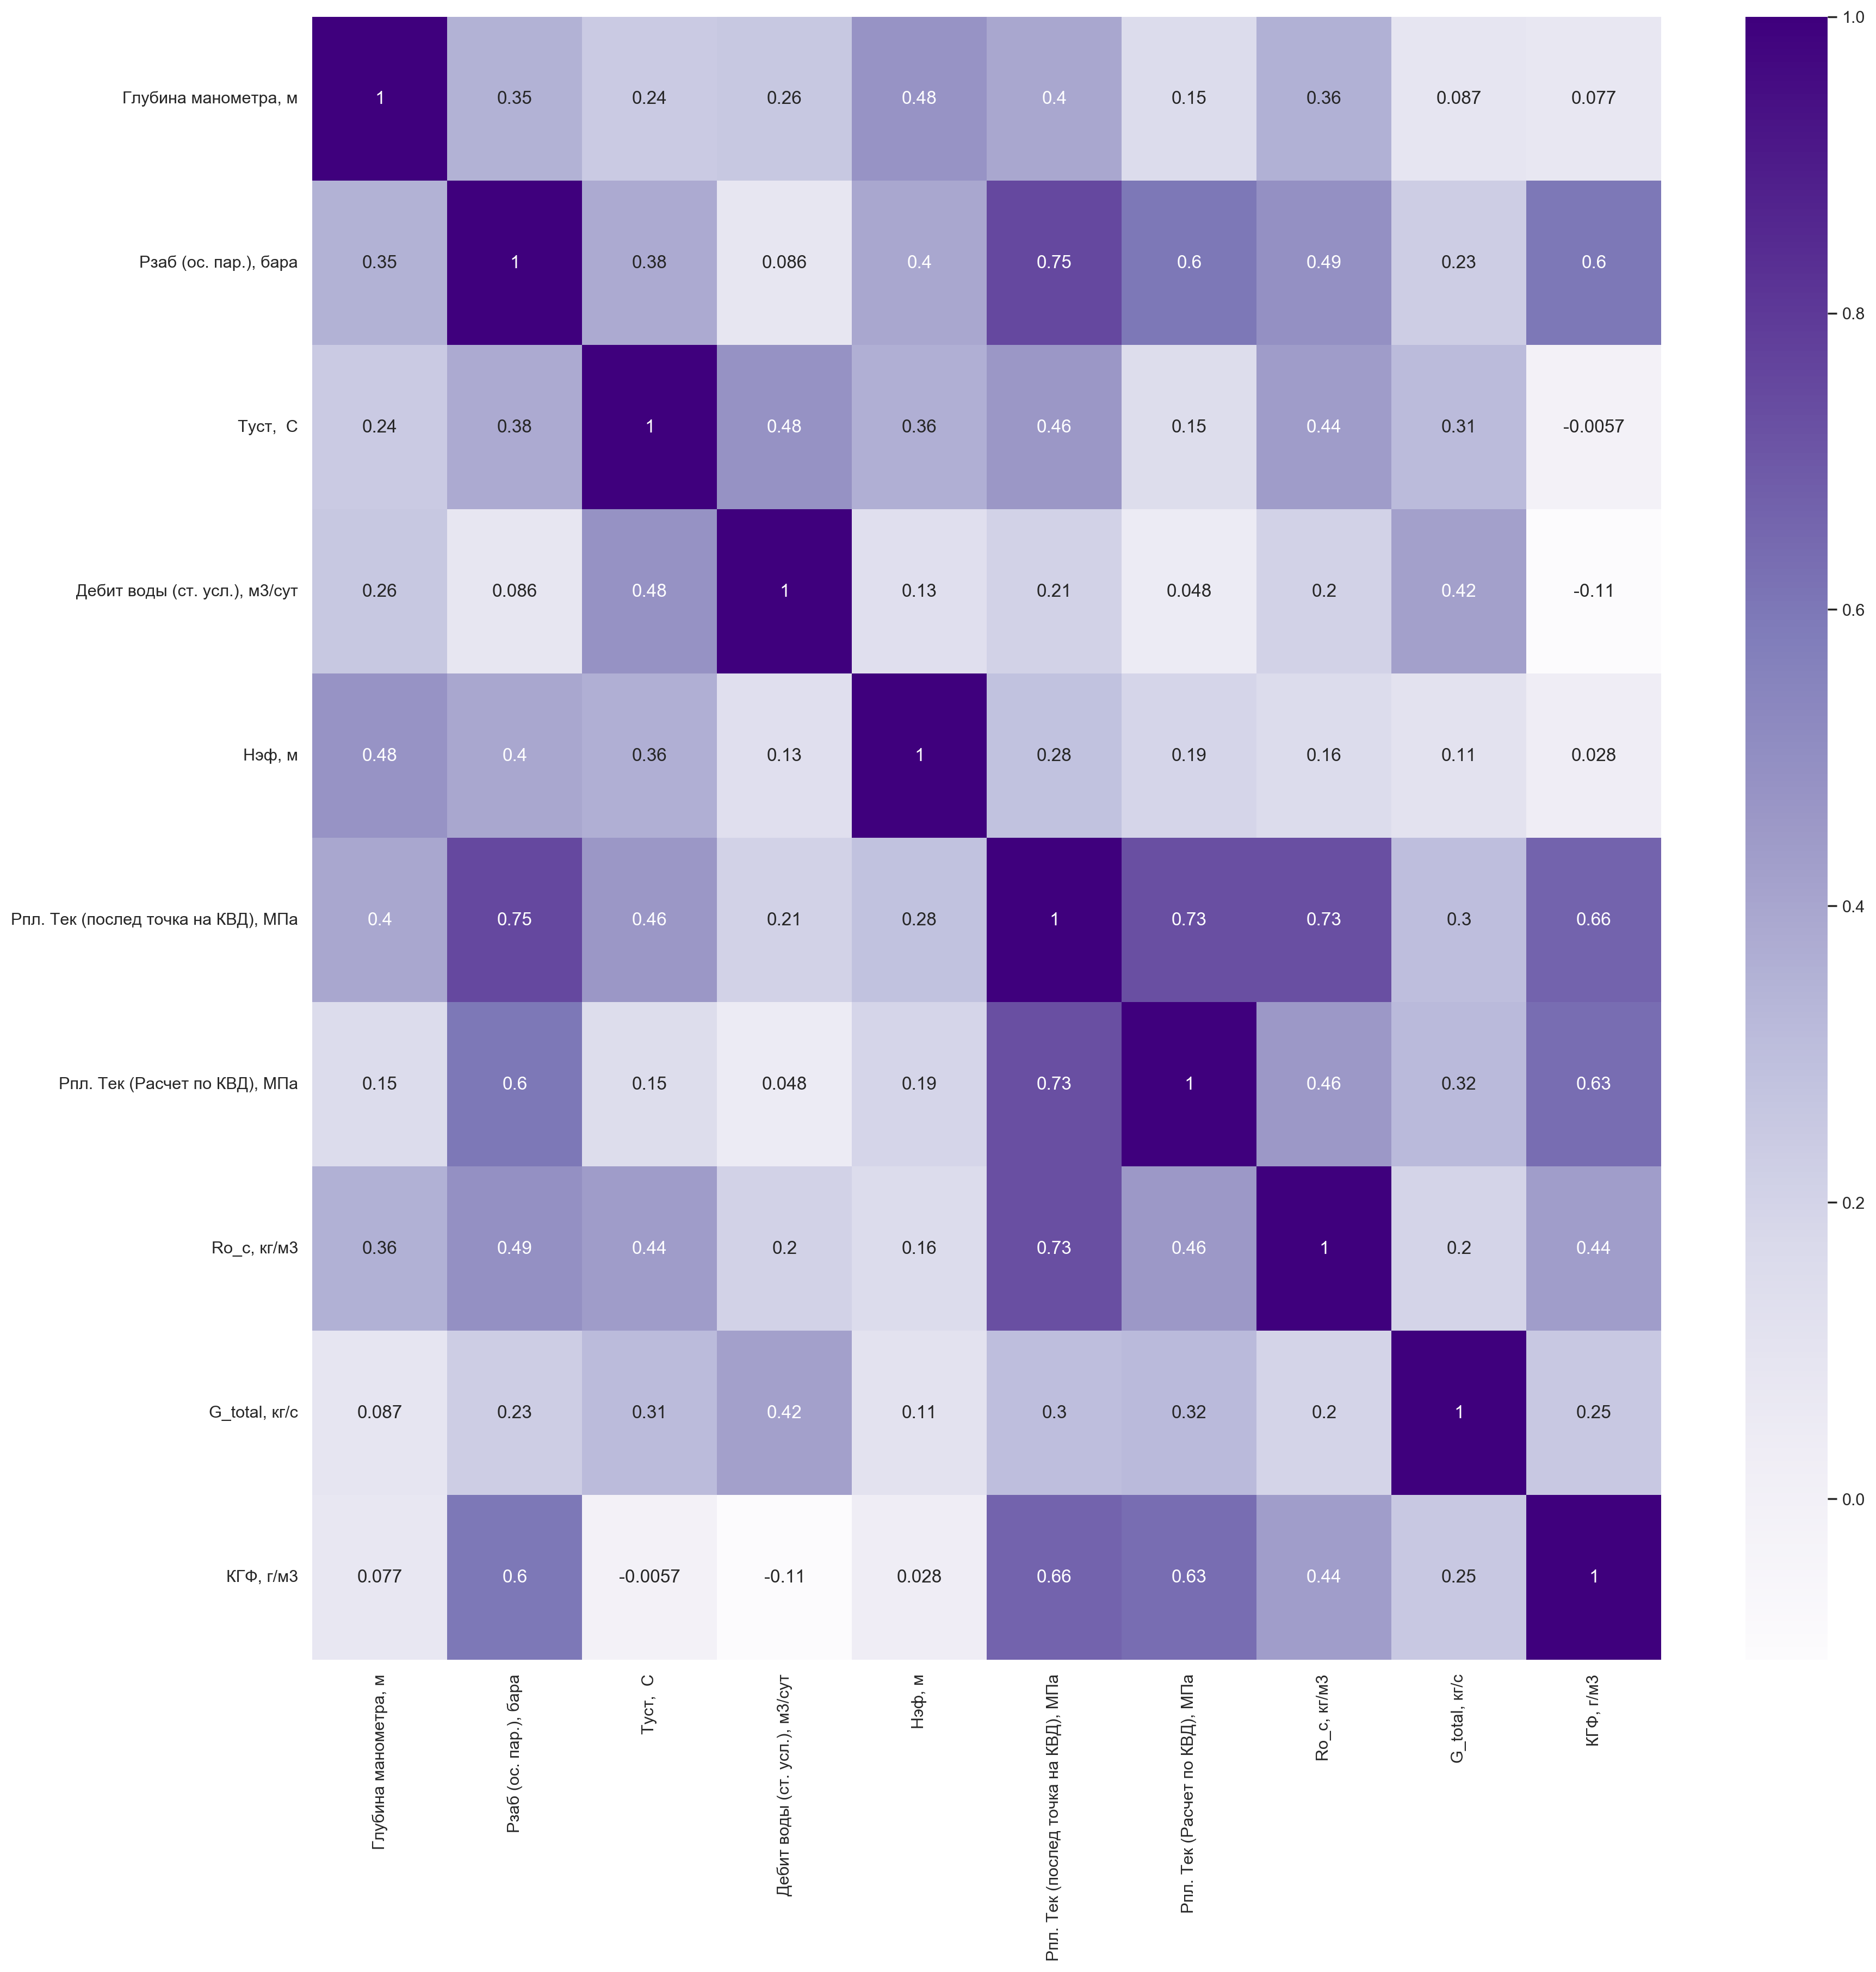

In [64]:
# вернемся на тепловую карту
data2 = data.apply(pd.to_numeric)
corr = data2.corr()
sns.set(rc={"figure.dpi":200})
sns.set(rc={'figure.figsize':(20,20)})
sns.heatmap(corr, cmap="Purples", annot=True)

In [45]:
data.shape

(93, 12)

In [46]:
# удалить признаки более 0.9 в приоритете по важности
del1 = ['Руст (ос. пар.), бара', 'Рзаб (ос. пар.), бара',# 'Руст (кон. реж.), бар',
        'Рзаб (кон. реж.), бар']
del2 = ['Дебит газа (ст. усл.), 1000 м3/сут', # 'Дебит смеси (ст. усл.), 1000 м3/сут',
      'Дебит гааз (лин. усл.), м3/сут']
#del3 = ['Дебит воды (ст. усл.), м3/сут',  'Дебит воды (лин. усл.), м3/сут']

def clear(info, mas):
    mx = '0'
    index = 0
    for i in mas:
        print(i, info[i])
        if info[i] > index:
            index = info[i]
            mx = i
    mas.remove(mx)
    return mas

data.drop(columns=clear(info, del1), inplace=True)

#for mas in [del1, del2]:
#    data.drop(columns=clear(info, mas), inplace=True)

#print(clear(info, del1))

Руст (ос. пар.), бара 0.04559132791752514
Рзаб (ос. пар.), бара 0.05585964768683023
Рзаб (кон. реж.), бар 0.05490860284239012


In [61]:
# удалить выбросы по внешним границам
perc_25, median, perc_75 = np.percentile(data_without_nans, [25, 50, 75])
c = ["G_total, кг/с", "КГФ, г/м3"]

for d in data.columns:
    if d not in c:
        perc_25, median, perc_75 = np.percentile(data[d], [25, 50, 75])
        iqr = perc_75 - perc_25
        mx = perc_75 + 1.5 * iqr
        mn = perc_25 - 1.5 * iqr
        data = data.loc[(data[d] > mn) & (data[d] < mx)]
        #print(d, iqr, mx, mn, sorted(list((pd.unique(data[d])))))
        #print("="*50)

In [48]:
# вернуться к ящикам с усами
#for d in data.columns:
#    print(sorted(list((pd.unique(data[d])))))
#    plt.figure(figsize=(3,3))
#    q = sns.boxplot(data[d])
#    plt.show()

In [49]:
data.shape

(93, 10)

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import datasets, tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import datasets, tree, ensemble

X = data.drop(columns=["G_total, кг/с", "КГФ, г/м3"])
y = data[["КГФ, г/м3"]]

for i in range(len(y)):
    y.iat[i, 0] = f(y.iat[i, 0])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=52)
clf_gini = ensemble.RandomForestClassifier(random_state=0,criterion="entropy").fit(X_train, y_train)
res1 = clf_gini.predict(X_test)
accuracy_score(y_test, res1)

/tmp/ipykernel_7937/810505416.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf_gini = ensemble.RandomForestClassifier(random_state=0,criterion="entropy").fit(X_train, y_train)


0.7857142857142857

In [51]:
data.columns

Index(['Глубина манометра, м', 'Рзаб (ос. пар.), бара', 'Туст,  С',
       'Дебит воды (ст. усл.), м3/сут', 'Нэф, м',
       'Рпл. Тек (послед точка на КВД), МПа', 'Рпл. Тек (Расчет по КВД), МПа',
       'Ro_c, кг/м3', 'G_total, кг/с', 'КГФ, г/м3'],
      dtype='object')